In [1]:
import os
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import random

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools

import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
import itertools
from keras.layers.normalization import BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

In [2]:
data_parent = '../input/adience-benchmark-gender-and-age-classification/AdienceBenchmarkGenderAndAgeClassification/'
print(os.listdir(data_parent))

['fold_0_data.txt', '__MACOSX', 'fold_3_data.txt', 'AdienceBenchmarkGenderAndAgeClassification', 'fold_2_data.txt', 'faces', 'fold_1_data.txt', 'fold_4_data.txt']


In [3]:

fold_0 = pd.read_csv(os.path.join(data_parent, 'fold_0_data.txt'), sep='\t')
fold_1 = pd.read_csv(os.path.join(data_parent, 'fold_1_data.txt'),sep='\t')
fold_2 = pd.read_csv(os.path.join(data_parent, 'fold_2_data.txt'),sep='\t')
fold_3 = pd.read_csv(os.path.join(data_parent, 'fold_3_data.txt'),sep='\t')
fold_4 = pd.read_csv(os.path.join(data_parent, 'fold_4_data.txt'),sep='\t')
total_data = pd.concat([fold_0, fold_1, fold_2, fold_3, fold_4], ignore_index=True)
total_data.head()

user_id                original_image  face_id       age gender     x  \
0  30601258@N03  10399646885_67c7d20df9_o.jpg        1  (25, 32)      f     0   
1  30601258@N03  10424815813_e94629b1ec_o.jpg        2  (25, 32)      m   301   
2  30601258@N03  10437979845_5985be4b26_o.jpg        1  (25, 32)      f  2395   
3  30601258@N03  10437979845_5985be4b26_o.jpg        3  (25, 32)      m   752   
4  30601258@N03  11816644924_075c3d8d59_o.jpg        2  (25, 32)      m   175   

      y    dx    dy  tilt_ang  fiducial_yaw_angle  fiducial_score  
0   414  1086  1383      -115                  30              17  
1   105   640   641         0                   0              94  
2   876   771   771       175                 -30              74  
3  1255   484   485       180                   0              47  
4    80   769   768       -75                   0              34

In [4]:
print('[+] length of the file:', len(total_data))
print('[+] unique values of Age:')
print(total_data.age.unique())
print('===================================================')
print('[+] Number of None Values in Age:')
print((total_data.age == 'None').sum())
print('[+] unique values of Gender:')
print(total_data.gender.unique())
print('===================================================')
print('[+] Number of nan values in Gender:')
print(total_data.gender.isna().sum())

[+] length of the file: 19370
[+] unique values of Age:
['(25, 32)' '(38, 43)' '(4, 6)' '(60, 100)' '(15, 20)' '(48, 53)'
 '(8, 12)' '(0, 2)' 'None' '(38, 48)' '35' '3' '55' '58' '22' '13' '45'
 '36' '23' '(38, 42)' '(8, 23)' '(27, 32)' '57' '56' '2' '29' '34' '42'
 '46' '32']
[+] Number of None Values in Age:
748
[+] unique values of Gender:
['f' 'm' nan 'u']
[+] Number of nan values in Gender:
779


# Gender chart

<AxesSubplot:ylabel='gender'>

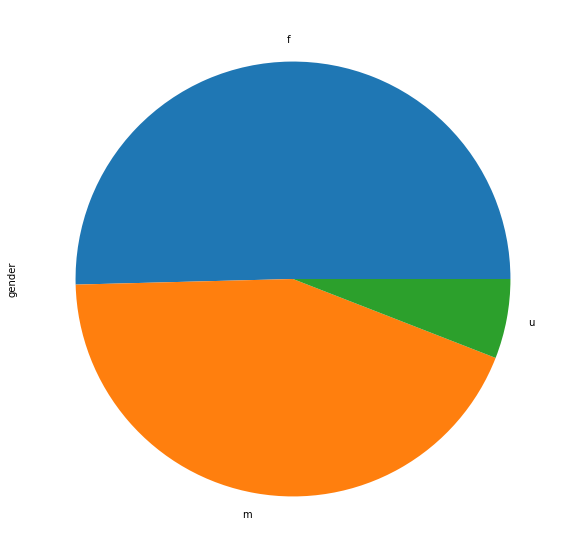

In [5]:
total_data.groupby('gender')['gender'].count().plot.pie(figsize=(10, 10))

# Age chart

<AxesSubplot:ylabel='age'>

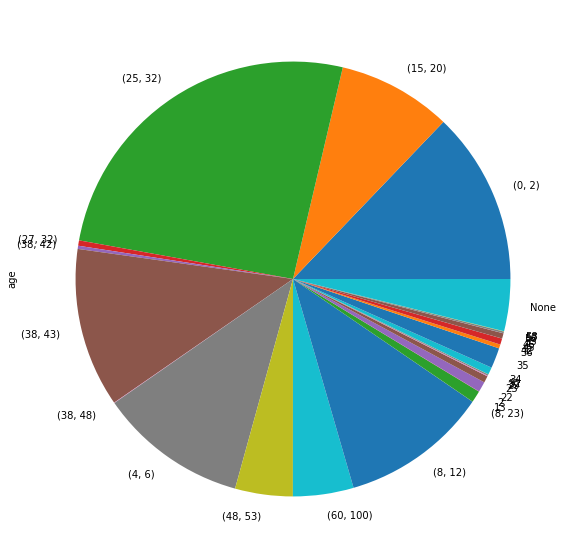

In [6]:
total_data.groupby('age')['age'].count().plot.pie(figsize=(10, 10))

[+] Image path: ../input/adience-benchmark-gender-and-age-classification/AdienceBenchmarkGenderAndAgeClassification/faces/30601258@N03/coarse_tilt_aligned_face.1.10399863183_a04f4c26a1_o.jpg
[+] Image shape: (600, 600, 3)
[!] Age: (25, 32) Gender: f


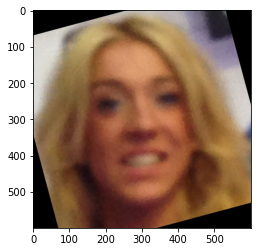

In [7]:
sample_num = 200
im_name = total_data.iloc[sample_num].original_image
im_path = os.path.join(data_parent, 'faces',str(total_data.iloc[sample_num].user_id), 'coarse_tilt_aligned_face.' + str(total_data.iloc[sample_num].face_id) + '.' + im_name)
print('[+] Image path:', im_path)
image = cv2.imread(im_path)
print('[+] Image shape:', image.shape)
print('[!] Age:', total_data.iloc[sample_num].age, 'Gender:', total_data.iloc[sample_num].gender)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

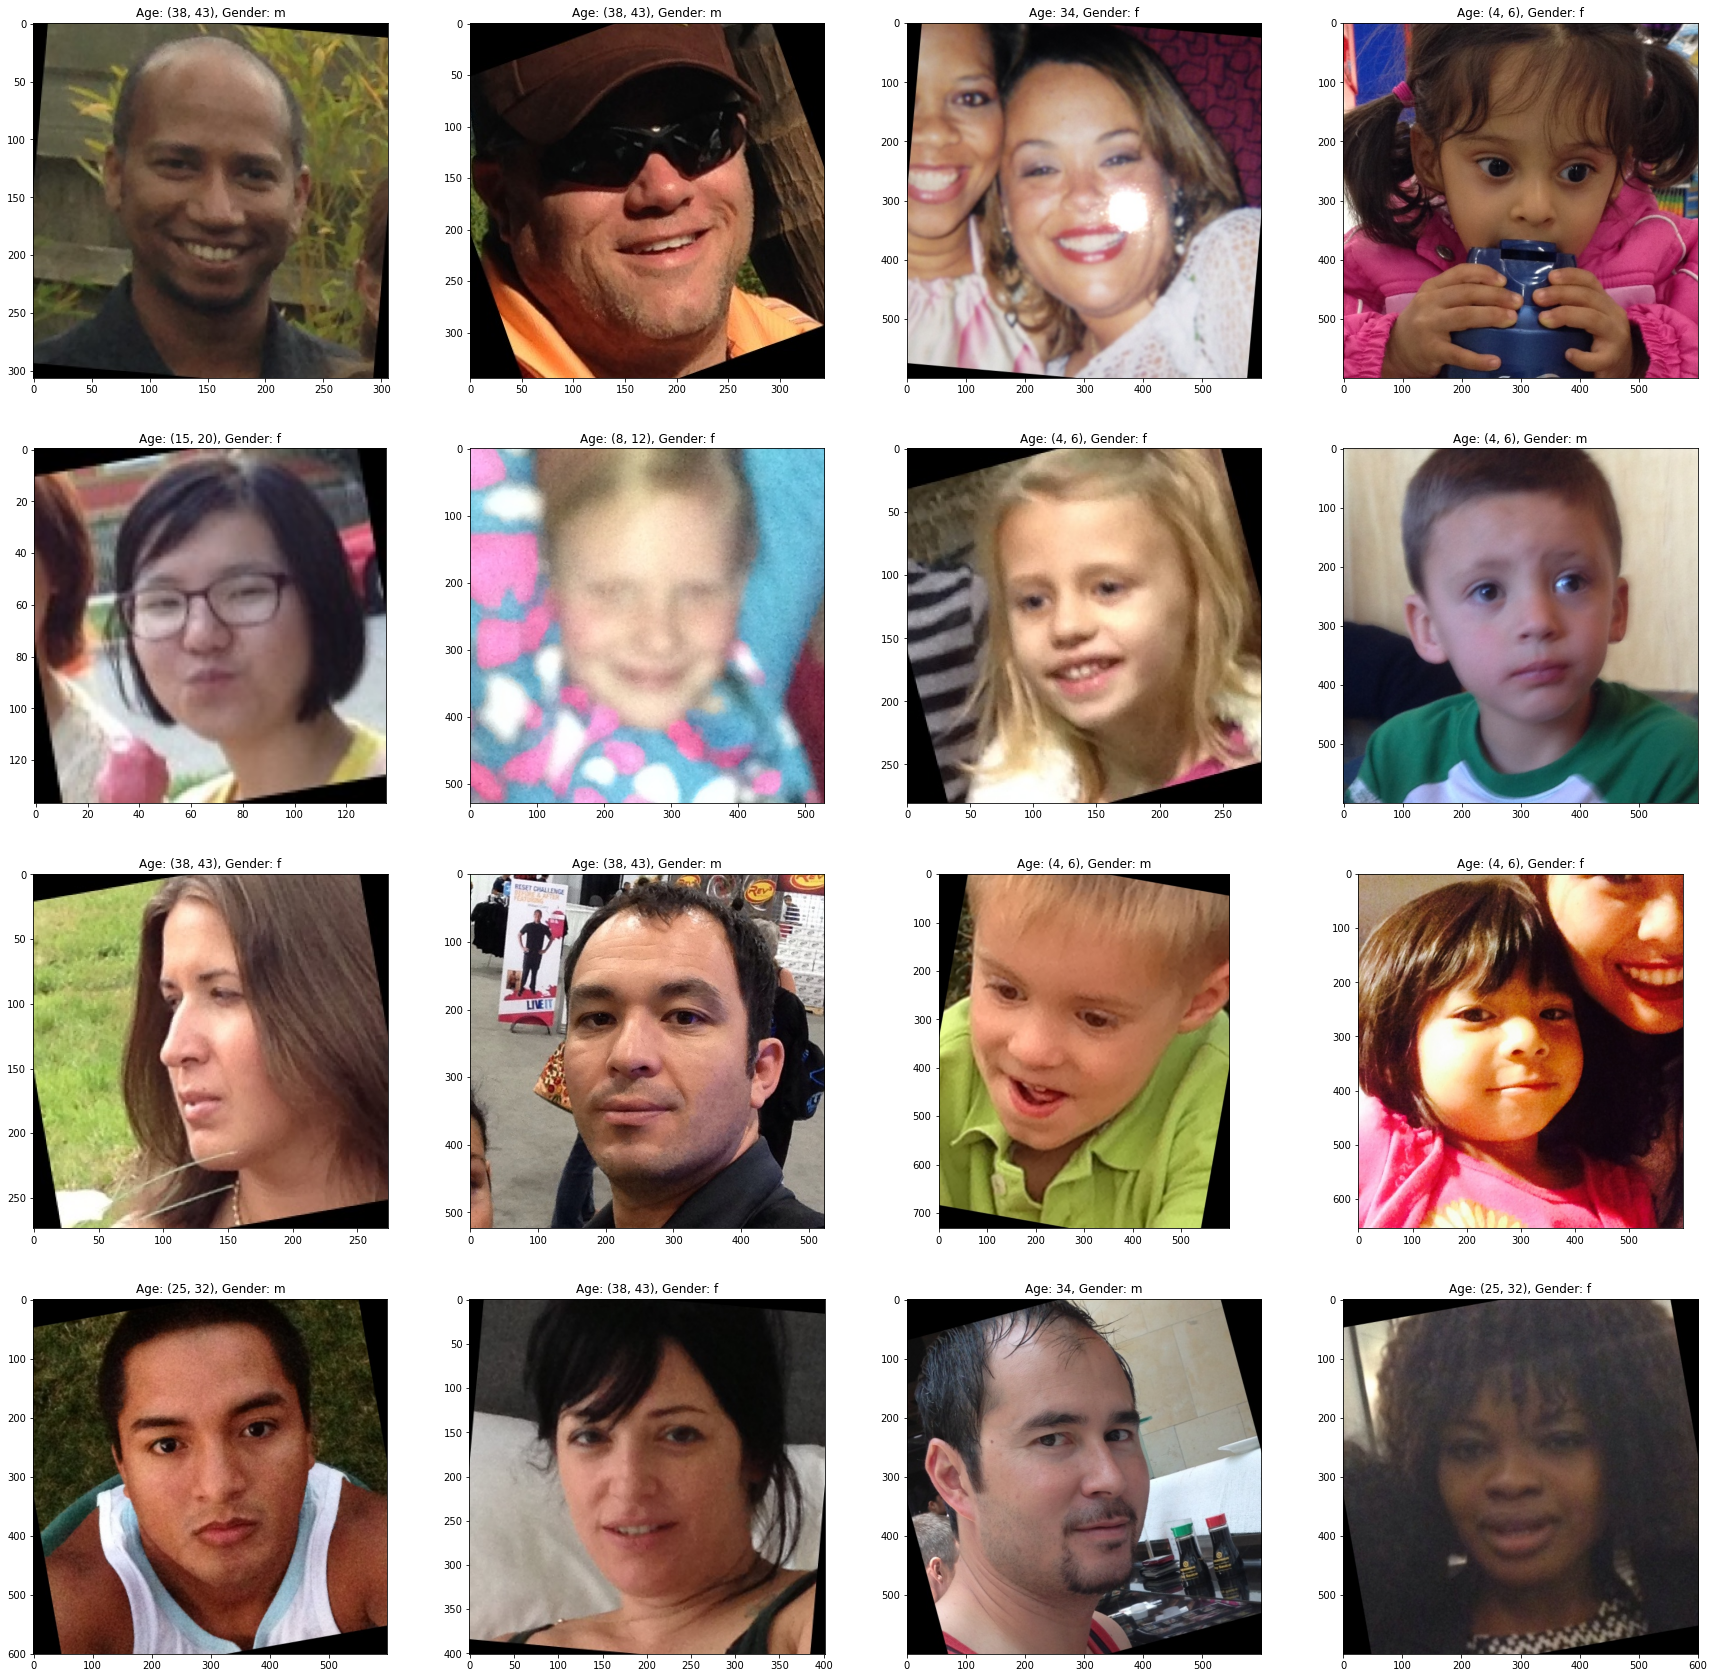

In [8]:
images = []
for _ in range(16):
    sample_num = random.randint(0, len(total_data))
    im_name = total_data.iloc[sample_num].original_image
    im_path = os.path.join(data_parent, 'faces',str(total_data.iloc[sample_num].user_id), 'coarse_tilt_aligned_face.' + str(total_data.iloc[sample_num].face_id) + '.' + im_name)
    image = cv2.imread(im_path)
    age = total_data.iloc[sample_num].age
    gender = total_data.iloc[sample_num].gender
    n_col = 4
    n_rows = 4
    images.append((image, age, gender))
    
fig, axs = plt.subplots(ncols=n_col, nrows=n_rows, figsize=(30,30))
count = 0
for i in range(n_rows):
      for j in range(n_col):
        axs[i][j].imshow(cv2.cvtColor(images[count][0], cv2.COLOR_BGR2RGB))
        axs[i][j].set_title(f'Age: {images[count][1]}, Gender: {images[count][2]}')
        count+=1
plt.show()

In [9]:
age_mapping = [('(0, 2)', '0-2'), ('2', '0-2'), ('3', '0-2'), ('(4, 6)', '4-6'), ('(8, 12)', '8-13'), ('13', '8-13'), ('22', '15-20'), ('(8, 23)','15-20'), ('23', '25-32'), ('(15, 20)', '15-20'), ('(25, 32)', '25-32'), ('(27, 32)', '25-32'), ('32', '25-32'), ('34', '25-32'), ('29', '25-32'), ('(38, 42)', '38-43'), ('35', '38-43'), ('36', '38-43'), ('42', '48-53'), ('45', '38-43'), ('(38, 43)', '38-43'), ('(38, 42)', '38-43'), ('(38, 48)', '48-53'), ('46', '48-53'), ('(48, 53)', '48-53'), ('55', '48-53'), ('56', '48-53'), ('(60, 100)', '60+'), ('57', '60+'), ('58', '60+')]
age_mapping_dict = {each[0]: each[1] for each in age_mapping}

drop_labels = []
for idx, each in enumerate(total_data.age):
    if each == 'None':
        drop_labels.append(idx)
    else:
        total_data.age.loc[idx] = age_mapping_dict[each]
total_data = total_data.drop(labels=drop_labels, axis=0) #droped None values
total_data.age.value_counts(dropna=False)

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


25-32    5296
38-43    2776
0-2      2509
8-13     2292
4-6      2140
15-20    1792
48-53     916
60+       901
Name: age, dtype: int64

In [10]:
total_data = total_data.dropna()
total_data['full_path'] = total_data.apply(lambda x: os.path.join(data_parent, 'faces', str(x.user_id), 'coarse_tilt_aligned_face.' + str(x.face_id) + '.' + x.original_image), axis=1)
total_data.age.unique(), len(total_data.age.unique()), total_data.gender.unique()

(array(['25-32', '38-43', '4-6', '60+', '15-20', '48-53', '8-13', '0-2'],
       dtype=object),
 8,
 array(['f', 'm', 'u'], dtype=object))

# change age and gender mapping 

In [11]:

gender_map = {'f':0, 
             'm':1,
             'u':2}
age_map = {
    '0-2'  :0,
    '4-6'  :1,
    '8-13' :2,
    '15-20':3,
    '25-32':4,
    '38-43':5,
    '48-53':6,
    '60+'  :7
}
total_data.gender = total_data.gender.replace(gender_map)
total_data.age=total_data.age.replace(age_map)

In [12]:
gender_labels = total_data.gender.values.tolist()
age_labels= total_data.age.values.tolist()
train_paths = total_data.full_path.values.tolist()
len(gender_labels), gender_labels[0],len(age_labels),age_labels[0], train_paths[0]

(18551,
 0,
 18551,
 4,
 '../input/adience-benchmark-gender-and-age-classification/AdienceBenchmarkGenderAndAgeClassification/faces/30601258@N03/coarse_tilt_aligned_face.1.10399646885_67c7d20df9_o.jpg')

In [13]:
from sklearn.preprocessing import OneHotEncoder

In [14]:
shuffle_list = list(zip(train_paths, gender_labels,age_labels))
shuffle_list = random.sample(shuffle_list, len(train_paths))
train_paths, gender_labels,age_labels = zip(*shuffle_list)
age_labels = np.array(list(age_labels)).reshape((-1, 1))
enc= OneHotEncoder()
age_labels = enc.fit_transform(age_labels).toarray() 

In [15]:
train_split = 0.75
train_sample = int(train_split * len(total_data))

train_data = train_paths[:train_sample]
validation_data = train_paths[train_sample:]

train_labels_gender = gender_labels[:train_sample]
validation_labels_gender = gender_labels[train_sample:]

train_labels_age=age_labels[:train_sample]
validation_labels_age=age_labels[train_sample:]
print("train data count:")
len(train_data), len(train_labels_gender), len(train_labels_age)
# print("validation data count:")
# len(validation_data), len(validation_labels)

train data count:


(13913, 13913, 13913)

In [16]:
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import multiprocessing

In [17]:
# train_dataset = tf.data.Dataset.from_tensor_slices((list(train_data), list(train_labels_gender),list(train_labels_age)))
# validation_dataset = tf.data.Dataset.from_tensor_slices((list(validation_data), list(validation_labels_gender),list(validation_labels_age)))
train_dataset = tf.data.Dataset.from_tensor_slices((list(train_data), list(train_labels_age)))
validation_dataset = tf.data.Dataset.from_tensor_slices((list(validation_data),list(validation_labels_age)))

In [18]:
# for path, target1,target2 in train_dataset.take(1):
#     print(path, target1,target2)
for path, target1 in train_dataset.take(1):
    print(path, target1)

tf.Tensor(b'../input/adience-benchmark-gender-and-age-classification/AdienceBenchmarkGenderAndAgeClassification/faces/115153697@N06/coarse_tilt_aligned_face.628.12095114783_6eb828c4fb_o.jpg', shape=(), dtype=string) tf.Tensor([0. 0. 0. 1. 0. 0. 0. 0.], shape=(8,), dtype=float64)


In [19]:
# def preprocess_func(path, label_gender,label_age):
#     image = tf.io.read_file(path)
#     image = tf.image.decode_jpeg(image, channels=3)
#     image = tf.image.resize(image, [128, 128]) / 255.0
        
#     return image, label_gender, label_age

def preprocess_func(path, label_age):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [128, 128]) / 255.0
        
    return image, label_age

In [20]:
import multiprocessing

In [21]:
train_batches = train_dataset.shuffle(1000).map(preprocess_func, num_parallel_calls=multiprocessing.cpu_count()).cache().batch(512).prefetch(tf.data.experimental.AUTOTUNE)
validation_batches = validation_dataset.shuffle(1000).map(preprocess_func, num_parallel_calls=multiprocessing.cpu_count()).cache().batch(512).prefetch(tf.data.experimental.AUTOTUNE)

(512, 128, 128, 3) (512, 8)
tf.Tensor([0. 0. 0. 0. 1. 0. 0. 0.], shape=(8,), dtype=float64)


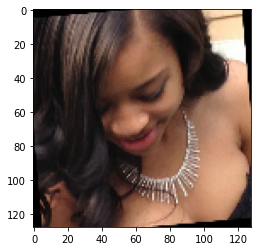

In [22]:
# for image, target1,target2 in train_batches.take(1):
#     print(image.shape, target1.shape,target2.shape)
#     image = tf.squeeze(image[0])
#     print(target1[0])
#     print(target2[0])
#     plt.imshow(image)
#     plt.show()
#     break

for image, target1 in train_batches.take(1):
    print(image.shape, target1.shape)
    image = tf.squeeze(image[0])
    print(target1[0])

    plt.imshow(image)
    plt.show()
    break

In [23]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(8, 3, padding='same', strides=2, activation='relu', input_shape=(128, 128, 3)),
#     tf.keras.layers.MaxPooling2D(),
#     tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
#     tf.keras.layers.Dropout(0.35),
    
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
#     tf.keras.layers.MaxPooling2D(),
#     tf.keras.layers.Dropout(0.45),
    
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
#     tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(8, activation = 'softmax')
])

model.compile(optimizer='adam', loss= tf.losses.CategoricalCrossentropy(), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 8)         224       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 16)        1168      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 16384)             0

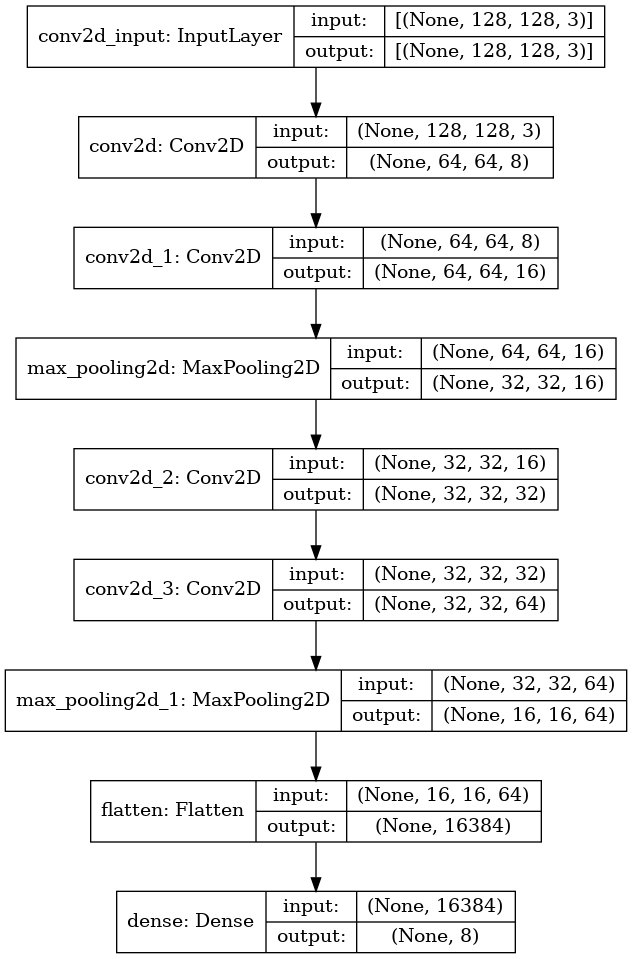

In [24]:
tf.keras.utils.plot_model(model, show_shapes=True)

# Age classification (training with results)

In [25]:
 history = model.fit(train_batches, epochs=25, validation_data = validation_batches)

Epoch 1/25
28/28 [==============================] - 100s 3s/step - loss: 1.9520 - accuracy: 0.2617 - val_loss: 1.7583 - val_accuracy: 0.3417
Epoch 2/25
28/28 [==============================] - 3s 118ms/step - loss: 1.7035 - accuracy: 0.3770 - val_loss: 1.6401 - val_accuracy: 0.4032
Epoch 3/25
28/28 [==============================] - 3s 115ms/step - loss: 1.6056 - accuracy: 0.4191 - val_loss: 1.5733 - val_accuracy: 0.4217
Epoch 4/25
28/28 [==============================] - 3s 113ms/step - loss: 1.5180 - accuracy: 0.4462 - val_loss: 1.4953 - val_accuracy: 0.4429
Epoch 5/25
28/28 [==============================] - 3s 117ms/step - loss: 1.4145 - accuracy: 0.4785 - val_loss: 1.4381 - val_accuracy: 0.4655
Epoch 6/25
28/28 [==============================] - 3s 115ms/step - loss: 1.3099 - accuracy: 0.5115 - val_loss: 1.4032 - val_accuracy: 0.4787
Epoch 7/25
28/28 [==============================] - 3s 115ms/step - loss: 1.2223 - accuracy: 0.5490 - val_loss: 1.3884 - val_accuracy: 0.4907
Epoch 8

In [26]:
#saving model
model.save("model.h5")

Evaluation

In [27]:
#evaluation
loss, accuracy = model.evaluate(train_batches, verbose=1)
loss_v, accuracy_v = model.evaluate(validation_batches, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

10/10 [==============================] - 1s 74ms/step - loss: 2.0014 - accuracy: 0.5410
Validation: accuracy = 0.540966  ;  loss_v = 2.001353
Test: accuracy = 0.822468  ;  loss = 0.463998


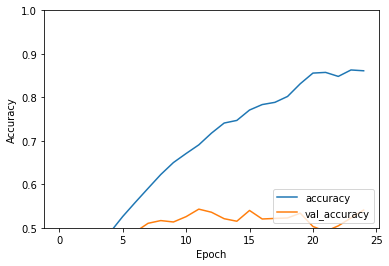

In [28]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')


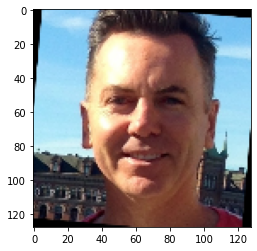

In [29]:
image_path = validation_data[7]
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (128, 128)) / 255.0
plt.imshow(image)
plt.show()

In [30]:
image = np.expand_dims(image, 0)
prediction = model.predict(image)

In [31]:
index = np.argmax(prediction)
decoding = {0:'0-2', 1:'4-6', 2:'8-13',3:'15-20',4:'25-32',5:'38-43',6:'48-53',7:'60+'}

print('[+] prediction is :', decoding[index]) 
# print(validation_data[7].age_labels)

[+] prediction is : 25-32


# gender classification with results

In [32]:
train_dataset2 = tf.data.Dataset.from_tensor_slices((list(train_data), list(train_labels_gender)))
validation_dataset2 = tf.data.Dataset.from_tensor_slices((list(validation_data),list(validation_labels_gender)))

In [33]:
for path, target1 in train_dataset2.take(1):
    print(path, target1)

tf.Tensor(b'../input/adience-benchmark-gender-and-age-classification/AdienceBenchmarkGenderAndAgeClassification/faces/115153697@N06/coarse_tilt_aligned_face.628.12095114783_6eb828c4fb_o.jpg', shape=(), dtype=string) tf.Tensor(0, shape=(), dtype=int32)


In [34]:
def preprocess_func(path, label_gender):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [128, 128]) / 255.0
        
    return image, label_gender

In [35]:
train_batches2 = train_dataset2.shuffle(1000).map(preprocess_func, num_parallel_calls=multiprocessing.cpu_count()).cache().batch(512).prefetch(tf.data.experimental.AUTOTUNE)
validation_batches2 = validation_dataset2.shuffle(1000).map(preprocess_func, num_parallel_calls=multiprocessing.cpu_count()).cache().batch(512).prefetch(tf.data.experimental.AUTOTUNE)

(512, 128, 128, 3) (512, 8)
tf.Tensor([0. 0. 0. 0. 0. 1. 0. 0.], shape=(8,), dtype=float64)


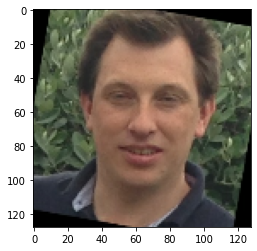

In [36]:
for image, target1 in train_batches.take(1):
    print(image.shape, target1.shape)
    image = tf.squeeze(image[0])
    print(target1[0])

    plt.imshow(image)
    plt.show()
    break

In [37]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(8, 3, padding='same', strides=2, activation='relu', input_shape=(128, 128, 3)),
#     tf.keras.layers.MaxPooling2D(),
#      tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
     tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
#     tf.keras.layers.MaxPooling2D(),
#      tf.keras.layers.Dropout(0.45),
    
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
     tf.keras.layers.Dropout(0.4),
    
     tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
      tf.keras.layers.Conv2D(258, 3, padding='same', activation='relu'),
     tf.keras.layers.MaxPooling2D(),
     tf.keras.layers.Dropout(0.5), 
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation = 'softmax')
])

model.compile(optimizer='adam', loss= tf.losses.CategoricalCrossentropy(), metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 64, 64, 8)         224       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 64, 64, 16)        1168      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 64)       

In [38]:
 history = model.fit(train_batches2, epochs=30, validation_data = validation_batches2)

Epoch 1/30
28/28 [==============================] - 35s 1s/step - loss: 0.0000e+00 - accuracy: 0.4402 - val_loss: 0.0000e+00 - val_accuracy: 0.4368
Epoch 2/30
28/28 [==============================] - 4s 130ms/step - loss: 0.0000e+00 - accuracy: 0.4402 - val_loss: 0.0000e+00 - val_accuracy: 0.4368
Epoch 3/30
28/28 [==============================] - 4s 130ms/step - loss: 0.0000e+00 - accuracy: 0.4402 - val_loss: 0.0000e+00 - val_accuracy: 0.4368
Epoch 4/30
28/28 [==============================] - 4s 126ms/step - loss: 0.0000e+00 - accuracy: 0.4402 - val_loss: 0.0000e+00 - val_accuracy: 0.4368
Epoch 5/30
28/28 [==============================] - 4s 126ms/step - loss: 0.0000e+00 - accuracy: 0.4402 - val_loss: 0.0000e+00 - val_accuracy: 0.4368
Epoch 6/30
28/28 [==============================] - 4s 128ms/step - loss: 0.0000e+00 - accuracy: 0.4402 - val_loss: 0.0000e+00 - val_accuracy: 0.4368
Epoch 7/30
28/28 [==============================] - 4s 133ms/step - loss: 0.0000e+00 - accuracy: 0.440

Evaluation

In [39]:

loss, accuracy = model.evaluate(train_batches2, verbose=1)
loss_v, accuracy_v = model.evaluate(validation_batches2, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

10/10 [==============================] - 1s 77ms/step - loss: 0.0000e+00 - accuracy: 0.4368
Validation: accuracy = 0.436826  ;  loss_v = 0.000000
Test: accuracy = 0.438008  ;  loss = 0.000000


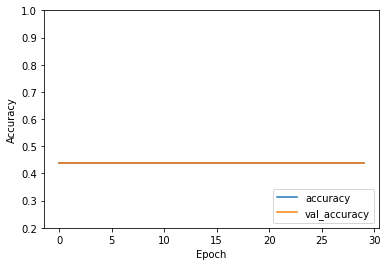

In [40]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.2, 1])
plt.legend(loc='lower right')

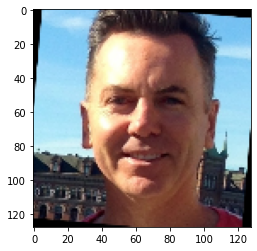

In [41]:
image_path = validation_data[7]
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (128, 128)) / 255.0
plt.imshow(image)
plt.show()

In [42]:
image = np.expand_dims(image, 0)
prediction = model.predict(image)

In [43]:
index = np.argmax(prediction)
decoding = {0:'f', 1:'m', 2:'u'}

print('[+] prediction is :', decoding[index]) 


[+] prediction is : f
